# Music Recommendation System using Deep Clustering

This notebook implements a music recommendation system using autoencoders and K-means clustering to find similar songs based on audio features.

## 1. Imports and Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA

In [2]:
from tensorflow.keras import layers, models
import tensorflow as tf

In [3]:
dataset = pd.read_csv('./dataset.csv')

## 2. Data Loading and Preprocessing

In [4]:
# Let's check for duplicates in the dataset
print("Checking for duplicate songs...")
duplicates = dataset[dataset.duplicated(['track_name', 'artists'], keep='first')]
if len(duplicates) > 0:
    print(f"Found {len(duplicates)} duplicate entries")
    print("Some examples:")
    print(duplicates[['artists', 'track_name']].head(10))
    print("Removing duplicates...")
    dataset = dataset.drop_duplicates(subset=['track_name', 'artists'], keep='first')
    print(f"Dataset size after removing duplicates: {len(dataset)}")
else:
    print("No duplicates found based on track_name and artists")

Checking for duplicate songs...
Found 32656 duplicate entries
Some examples:
                                 artists             track_name
18             Jason Mraz;Colbie Caillat                  Lucky
20                            Jason Mraz              I'm Yours
22  A Great Big World;Christina Aguilera          Say Something
28                            Jason Mraz      Winter Wonderland
29                            Jason Mraz      Winter Wonderland
30                            Jason Mraz      Winter Wonderland
31                            Jason Mraz      Winter Wonderland
34              Brandi Carlile;Sam Smith           Party of One
35              Brandi Carlile;Sam Smith           Party of One
39                           KT Tunstall  Lonely This Christmas
Removing duplicates...
Dataset size after removing duplicates: 81344


In [5]:
pd.set_option('display.max_columns', None)
dataset.head()

,index,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [8]:
df = dataset.copy()
print(df.columns)
numericalCols = ["popularity", "duration_ms", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]
categoricalCols = ["time_signature", "key", "mode","explicit"]
droppedMetaData = ["artists", "album_name", "track_name"]
values = {}

le = LabelEncoder()
df["explicit"] = le.fit_transform(df["explicit"])

# One-hot encode track_genre and convert to DataFrame
ohe = OneHotEncoder(sparse_output=False)  # Return dense array instead of sparse
genre_encoded = ohe.fit_transform(df[["track_genre"]])

# Create DataFrame with proper column names
genre_columns = [f'genre_{genre}' for genre in ohe.categories_[0]]
genreDF = pd.DataFrame(genre_encoded, columns=genre_columns, index=df.index)

df = df.drop(columns=[ "track_id", "track_genre"])
df[numericalCols] = StandardScaler().fit_transform(dataset[numericalCols])
df = df.join(genreDF)

df.head(10)

Index(['index', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')


,index,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre_acoustic,genre_afrobeat,genre_alt-rock,genre_alternative,genre_ambient,genre_anime,genre_black-metal,genre_bluegrass,genre_blues,genre_brazil,genre_breakbeat,genre_british,genre_cantopop,genre_chicago-house,genre_children,genre_chill,genre_classical,genre_club,genre_comedy,genre_country,genre_dance,genre_dancehall,genre_death-metal,genre_deep-house,genre_detroit-techno,genre_disco,genre_disney,genre_drum-and-bass,genre_dub,genre_dubstep,genre_edm,genre_electro,genre_electronic,genre_emo,genre_folk,genre_forro,genre_french,genre_funk,genre_garage,genre_german,genre_gospel,genre_goth,genre_grindcore,genre_groove,genre_grunge,genre_guitar,genre_happy,genre_hard-rock,genre_hardcore,genre_hardstyle,genre_heavy-metal,genre_hip-hop,genre_honky-tonk,genre_house,genre_idm,genre_indian,genre_indie,genre_indie-pop,genre_industrial,genre_iranian,genre_j-dance,genre_j-idol,genre_j-pop,genre_j-rock,genre_jazz,genre_k-pop,genre_kids,genre_latin,genre_latino,genre_malay,genre_mandopop,genre_metal,genre_metalcore,genre_minimal-techno,genre_mpb,genre_new-age,genre_opera,genre_pagode,genre_party,genre_piano,genre_pop,genre_pop-film,genre_power-pop,genre_progressive-house,genre_psych-rock,genre_punk,genre_punk-rock,genre_r-n-b,genre_reggae,genre_reggaeton,genre_rock,genre_rock-n-roll,genre_rockabilly,genre_romance,genre_sad,genre_salsa,genre_samba,genre_sertanejo,genre_show-tunes,genre_singer-songwriter,genre_ska,genre_sleep,genre_soul,genre_spanish,genre_study,genre_swedish,genre_synth-pop,genre_tango,genre_techno,genre_trance,genre_trip-hop,genre_turkish,genre_world-music
0,0,Gen Hoshino,Comedy,Comedy,1.973595,-0.006401,0,0.656701,-0.672851,1,0.348357,0,0.463078,-0.875018,-0.557105,0.697427,0.955723,-1.136061,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,1.047605,-0.702198,0,-0.783568,-1.813442,1,-1.628934,1,-0.108828,1.748240,-0.557091,-0.598786,-0.745232,-1.482176,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,1.150493,-0.176710,0,-0.682299,-1.067225,0,-0.214914,1,-0.285459,-0.352014,-0.557108,-0.518088,-1.303357,-1.520578,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,1.870707,-0.253049,0,-1.649981,-2.224829,0,-1.870228,1,-0.451801,1.692351,-0.556895,-0.442433,-1.216032,1.978013,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## 3. Deep Clustering

### 3.1 Autoencoder Architecture

In [26]:
def buildAutoencoder(X):
  inputDim = X.shape[1]
  encodingDim = inputDim // 3 # A common practice is to have the encoding dimension smaller

  inputLayer = layers.Input(shape=(inputDim,))
  encoder = layers.Dense(encodingDim, activation="relu")(inputLayer)
  outputLayer = layers.Dense(inputDim, activation="linear")(encoder) # Output layer should match input dimension

  autoencoder = models.Model(inputs=inputLayer, outputs=outputLayer)
  encoderModel = models.Model(inputs=inputLayer, outputs=encoder)

  autoencoder.compile(optimizer="adam", loss="mse") # Using mse for numerical data

  return (autoencoder, encoderModel)

### 3.2 Autoencoder Training

In [9]:
numerical_trainSet = df[numericalCols + categoricalCols + genre_columns]

In [60]:
autoEncoder, encoder = buildAutoencoder(numerical_trainSet)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

losses = []

for x in range(100):
    print(f"Training epoch batch {x + 1}...")
    history = autoEncoder.fit(numerical_trainSet, numerical_trainSet, 
                    epochs=100, batch_size=32, shuffle=True, 
                    callbacks=[
                        earlyStopping
                    ])

    losses.append(history.history['loss'])
    print(f"Current loss: {losses[-1]}")
    history.history.clear() 
    
    if earlyStopping.stopped_epoch > 0:
        print(f"Training stopped early at epoch {earlyStopping.stopped_epoch} to prevent overfitting! Yay!")
        break

Training epoch batch 1...
Epoch 1/100
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 2s 529us/step - loss: 0.0817
Epoch 2/100
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - loss: 0.0061
Epoch 3/100
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - loss: 0.0058
Epoch 4/100
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 1s 500us/step - loss: 0.0056
Epoch 5/100
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - loss: 0.0055
Epoch 6/100
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - loss: 0.0054
Epoch 7/100
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - loss: 0.0054
Epoch 8/100
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - loss: 0.0053
Epoch 9/100
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - loss: 0.0053
Epoch 10/100
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step - loss: 0.0052
Epoch 11/100
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step - loss: 0.0052
Epoch 12/100
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - loss: 0.0052
Epoch 13/100
2542/2542 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step - loss: 0.0052
Epoch 14/100
2542/2542 ━━━━━━━━━━━

### 3.3 Training Loss Visualization

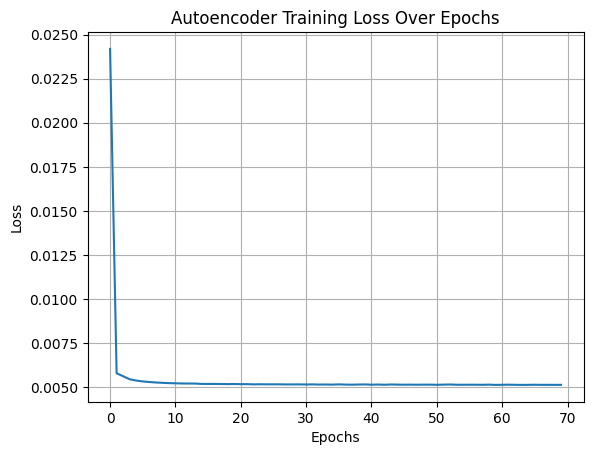

In [28]:
import matplotlib.pyplot as plt
plt.plot(np.concatenate(losses))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Autoencoder Training Loss Over Epochs')
plt.grid(True)
plt.show()

### 3.4 Model Loading (Alternative)

In [23]:
# If pre-existing autoencoder & encoder models exist, load them
autoEncoder = tf.keras.models.load_model('./models/autoencoder_model6.keras')
encoder = tf.keras.models.load_model('./models/encoder_model6.keras')

## 4. Latent Representation Extraction

In [29]:
XLatents = encoder.predict(df[numerical_trainSet.columns])

2542/2542 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step


## 5. Music Recommendation System

In [43]:

from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=6, metric="euclidean")  # 1 original + 5 rec
nn.fit(XLatents)

NearestNeighbors(metric='euclidean', n_neighbors=6)

In [55]:
def recommend_songs_DC(song, top_n=5):
    if not isinstance(song, pd.Series):
        raise ValueError("recommend_songs_DC expects a pandas Series row from `df`. Use findSongRow(...) on `df`.")

    label = song.name
    # positional index (0..n-1) that matches order of XLatents and how NearestNeighbors was fitted
    pos = df.index.get_loc(label)
    print(f"Finding recommendations for: {df.iloc[pos]['artists']} - {df.iloc[pos]['track_name']} - {df.iloc[pos]['index']}")


    # Reshape to 2D array: (1, n_features) - one sample with multiple features
    song_latent = XLatents[pos].reshape(1, -1)

    distances, indices = nn.kneighbors(song_latent, n_neighbors=top_n+1) # +1 to include the original song

    print("Closest neighbors:")

    count = -1
    
    for i, (idx, dist) in enumerate(zip(indices[0], distances[0])):
        song_info = df.iloc[idx]
        song_key = f"{song_info['artists']} - {song_info['track_name']}"
        
        count += 1
        
        if count == 0:
            print(f"{count}. {song_key} (Original - similarity: {1-dist:.3f})")
        else:
            print(f"{count}. {song_key} (similarity: {1-dist:.3f})")
        
        # Stop when we have enough unique recommendations
        if count >= top_n:  # +1 to include the original song
            break



### 5.1 Testing the Recommendation System

In [56]:
recommend_songs_DC(dataset.iloc[0], top_n=5)

Finding recommendations for: Gen Hoshino - Comedy - 0
Closest neighbors:
0. Gen Hoshino - Comedy (Original - similarity: 1.000)
1. Jason Mraz - Have It All (similarity: 0.462)
2. Violent Femmes - Blister In The Sun (similarity: 0.453)
3. Jason Mraz;Colbie Caillat - Lucky (similarity: 0.410)
4. Ben Rector - It Would Be You (similarity: 0.399)
5. Gen Hoshino - SUN (similarity: 0.386)


In [34]:
def findSongRow(song_name, artist_name):
    matches = df[(df['track_name'].str.lower() == song_name.lower()) & 
                      (df['artists'].str.lower() == artist_name.lower())]
    
    if not matches.empty:
        return matches.iloc[0]
    else:
        return None

In [57]:
fireflies = findSongRow("Fireflies", "Owl City")

recommend_songs_DC(fireflies, top_n=5)

Finding recommendations for: Owl City - Fireflies - 56113
Closest neighbors:
0. Owl City - Fireflies (Original - similarity: 1.000)
1. Simple Plan - Perfect (similarity: 0.758)
2. Linkin Park - Final Masquerade (similarity: 0.720)
3. The Script - Superheroes (similarity: 0.719)
4. Rammstein - Was ich liebe (similarity: 0.688)
5. Dr. Dog - Where'd All the Time Go? (similarity: 0.684)


## 6. Model Saving

In [19]:
import os

# Extract the directory path from the dataset file path
dataset_path = './models/'
save_directory = os.path.dirname(dataset_path)

# Define the path to save the autoencoder model
autoencoder_save_path = os.path.join(save_directory, 'autoencoder_model6.keras')
encoder_save_path = os.path.join(save_directory, 'encoder_model6.keras')

# Save the autoencoder model
autoEncoder.save(autoencoder_save_path)
encoder.save(encoder_save_path)

print(f"Autoencoder model saved to: {autoencoder_save_path}")
print(f"Encoder model saved to: {encoder_save_path}")

Autoencoder model saved to: ./models\autoencoder_model6.keras
Encoder model saved to: ./models\encoder_model6.keras


# 7. Evaluation

In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np


Xrecon = autoEncoder.predict(numerical_trainSet)
# X = original input, X_recon = autoencoder output
recon_error = mean_squared_error(df[numerical_trainSet.columns], Xrecon)
print("Reconstruction MSE:", recon_error)

2542/2542 ━━━━━━━━━━━━━━━━━━━━ 1s 312us/step
Reconstruction MSE: 0.005168143659830093


In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

kmeans = KMeans(n_clusters=10, random_state=42).fit(XLatents)
labels = kmeans.labels_

print("Silhouette Score:", silhouette_score(XLatents, labels))
print("Davies-Bouldin:", davies_bouldin_score(XLatents, labels))


Silhouette Score: 0.10961931
Davies-Bouldin: 2.173468861549589


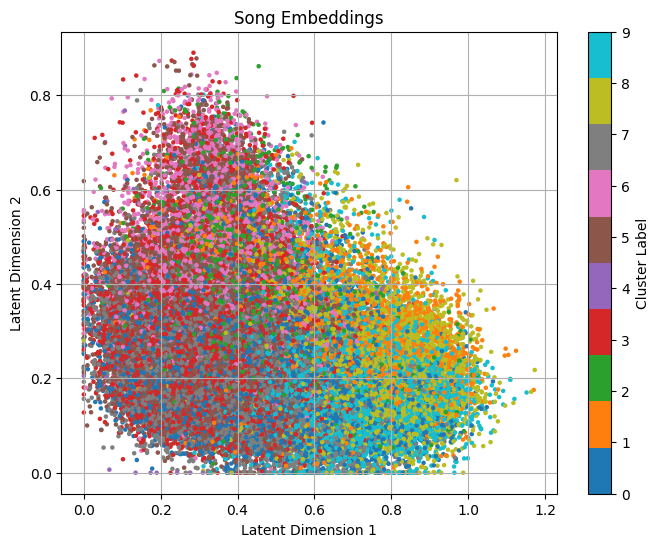

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

scatter = plt.scatter(XLatents[:, 0], XLatents[:, 1], c=labels, cmap='tab10', s=5)
plt.title('Song Embeddings')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()

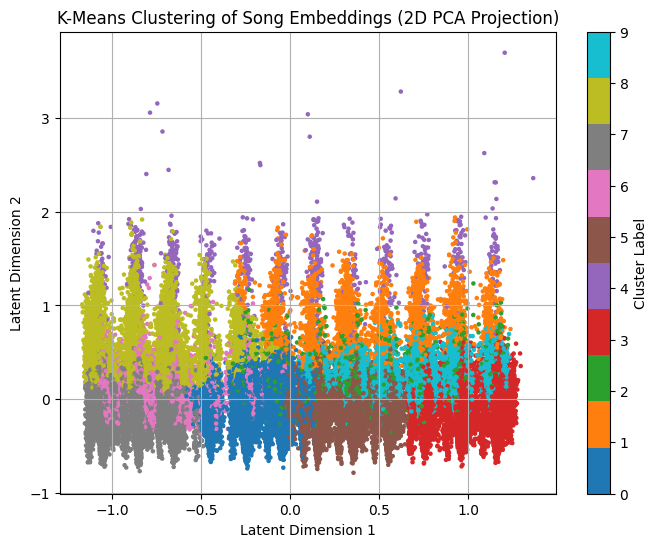

In [47]:
plt.figure(figsize=(8, 6))
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(XLatents)


scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', s=5)
plt.title('K-Means Clustering of Song Embeddings (2D PCA Projection)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()